In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

import numpy as np
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
X, Y = make_blobs(n_samples=300, centers=2, random_state=45, cluster_std=0.6)
Y[Y ==0] = -1

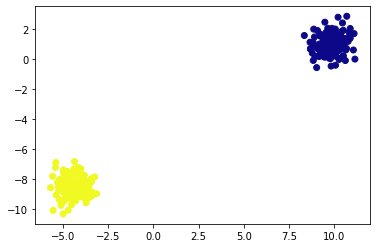

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='plasma')

In [4]:
from sklearn.svm import SVC
model = SVC(kernel ='linear', C=1e10)
model.fit(X, Y)

SVC(C=10000000000.0, kernel='linear')

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax == None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

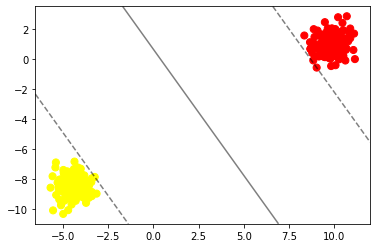

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
plot_svc_decision_function(model)

In [13]:
model.support_vectors_

array([[ 9.01725068, -0.56723264],
       [-3.23676301, -7.84961627]])

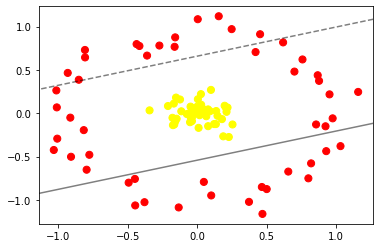

In [14]:
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

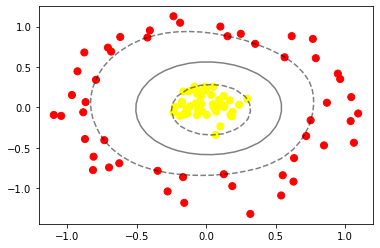

In [16]:
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='rbf', C=1e6).fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
           s=300, lw=1, facecolors='none')

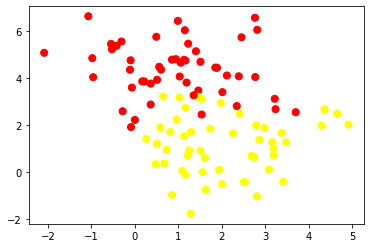

In [17]:
X,y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

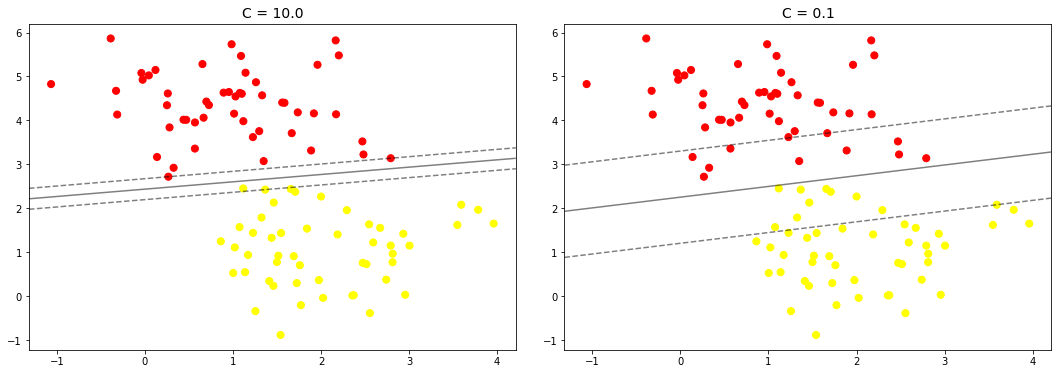

In [139]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors='none')
    axi.set_title('C = {0:.1f}'.format(C), size=14)

In [162]:
def hinge_loss(scores, labels):
#     assert len(scores.shape) == 1
#     assert len(labels.shape) == 1
    return torch.clamp(1 - scores * labels, min=0).mean()

class SVM(BaseEstimator, ClassifierMixin):
    @staticmethod
    def linear(x_1, x_2):
        return x_1 @ x_2.T
    
    def __init__(
        self,
        lr: float=1e-3,
        epochs: int=2,
        batch_size: int=64,
        lmbd: float=1e-4,
        kernel_function=None,
        verbose: bool=False,
    ):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmbd = lmbd
        self.kernel_function = kernel_function or SVM.linear
        self.verbose = verbose
        self.fitted = False
    
    
    def __repr__(self):
        return f'SVM model, fitted: {self.fitted}'

    
    def fit(self, X, Y):
        n_obj = len(X)
        X, Y = torch.tensor(X), torch.tensor(Y)
        K = self.kernel_function(X, X)
        
        self.betas = torch.rand((n_obj, 1), dtype=X.dtype, requires_grad=True)
        self.bias = torch.rand(1, requires_grad=True)   
        
        optimizer = torch.optim.SGD((self.betas, self.bias), lr=self.lr)
        
        for epoch in range(self.epochs):
            perm = torch.randperm(n_obj)
            sum_loss = 0.0
            for i in range(0, n_obj, self.batch_size):
                batch_inds = perm[i:i + self.batch_size]
                x_batch = X[batch_inds]
                y_batch = Y[batch_inds]
                k_batch = K[batch_inds]
                
                optimizer.zero_grad()
                
                preds = k_batch @ self.betas + self.bias
                loss = self.lmbd * self.betas[batch_inds].T @ k_batch @ self.betas + hinge_loss(preds, y_batch)
                loss.backward()
                optimizer.step()
                
                sum_loss += loss.item()
                
            if self.verbose:
                print(f"Epoch {epoch}, Loss: {sum_loss / self.batch_size: .2f}")
        self.X = X
        self.fitted = True
        return self
    
    def predict_scores(self, batch):
        with torch.no_grad():
            batch = torch.from_numpy(batch)
            K = self.kernel_function(batch, self.X)
            return torch.squeeze(K @ self.betas + self.bias)
        
    def predict(self, batch):
        scores = self.predict_scores(batch)
        answer = np.full(len(batch), -1, dtype=np.int64)
        answer[ scores > 0 ]  =1 
        return answer

In [166]:
model = SVM(epochs=50, verbose=True)
model

SVM model, fitted: False

In [167]:
model.fit(X, y)

Epoch 0, Loss:  0.05
Epoch 1, Loss:  0.05
Epoch 2, Loss:  0.05
Epoch 3, Loss:  0.05
Epoch 4, Loss:  0.05
Epoch 5, Loss:  0.05
Epoch 6, Loss:  0.05
Epoch 7, Loss:  0.05
Epoch 8, Loss:  0.05
Epoch 9, Loss:  0.05
Epoch 10, Loss:  0.05
Epoch 11, Loss:  0.05
Epoch 12, Loss:  0.05
Epoch 13, Loss:  0.05
Epoch 14, Loss:  0.05
Epoch 15, Loss:  0.05
Epoch 16, Loss:  0.05
Epoch 17, Loss:  0.05
Epoch 18, Loss:  0.05
Epoch 19, Loss:  0.05
Epoch 20, Loss:  0.05
Epoch 21, Loss:  0.05
Epoch 22, Loss:  0.05
Epoch 23, Loss:  0.05
Epoch 24, Loss:  0.05
Epoch 25, Loss:  0.05
Epoch 26, Loss:  0.05
Epoch 27, Loss:  0.05
Epoch 28, Loss:  0.05
Epoch 29, Loss:  0.05
Epoch 30, Loss:  0.05
Epoch 31, Loss:  0.05
Epoch 32, Loss:  0.05
Epoch 33, Loss:  0.05
Epoch 34, Loss:  0.05
Epoch 35, Loss:  0.05
Epoch 36, Loss:  0.05
Epoch 37, Loss:  0.05
Epoch 38, Loss:  0.05
Epoch 39, Loss:  0.05
Epoch 40, Loss:  0.05
Epoch 41, Loss:  0.05
Epoch 42, Loss:  0.05
Epoch 43, Loss:  0.05
Epoch 44, Loss:  0.05
Epoch 45, Loss:  0.0

SVM model, fitted: True

In [170]:
predictions = model.predict(X)
accuracy_score(y, predictions)

0.5